In [41]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import pylab 

In [102]:
df = pd.read_csv('./allfile_counts.csv', delimiter= '\t', header=0, index_col=0)

In [103]:
df

,45360240,45360241,45360242,45360243,45360244,45360245,45360246,45360247,ENSSSCG00000000001,ENSSSCG00000000002,...,ENSSSCG00000031067,ENSSSCG00000031068,ENSSSCG00000031069,ENSSSCG00000031070,no_feature,ambiguous,too_low_aQual,not_aligned,alignment_not_unique,dpi
-5001,0,6,2,2,2,6,6,20,2,31,...,0,0,0,0,3337306,2607380,0,0,3166590,0
-5001,74,434,191,390,675,3150,5821,12027,6,68,...,0,0,0,0,3283594,1037767,0,0,2962060,14
-5001,14,201,78,83,107,405,529,984,4,148,...,0,0,0,0,4075261,1049080,0,0,3441599,21
-5001,9,51,19,9,18,48,37,71,5,101,...,0,0,0,0,4349788,1215308,0,0,3512273,28
-5002,0,4,0,0,0,5,2,7,12,219,...,0,0,0,0,6896283,1274445,0,0,5281607,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-5178,355,7379,4685,7494,8209,33838,41300,90438,2,70,...,0,0,0,0,3050584,681988,0,0,2690833,4
-5178,1462,16829,5522,6261,6316,23293,24144,38913,4,90,...,0,0,0,0,3356654,1014682,0,0,3047038,7
-5186,245,3645,1182,1303,1680,6373,7088,11133,1,89,...,0,0,0,0,3358963,1497726,0,0,2794923,10
-5186,315,2600,685,522,555,1968,1585,2482,1,32,...,0,0,0,0,3343517,1428249,0,0,2887114,4


In [116]:
eg = df[['ENSSSCG00000000574', 'dpi']]

In [44]:
dpi = df['dpi']

In [45]:
de = pd.read_csv('./deGenes.txt', delimiter= '\t', header=0, index_col=0)
de.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSSSCG00000000002,98.064004,0.616469,0.125165,4.925267,8.424518e-07,0.000312
ENSSSCG00000000021,15.407363,0.905129,0.222525,4.067538,4.751243e-05,0.004059
ENSSSCG00000000077,713.963209,-0.222813,0.064664,-3.445682,5.696208e-04,0.020029
ENSSSCG00000000086,5.280889,1.451773,0.350814,4.138302,3.498862e-05,0.003255
ENSSSCG00000000091,604.824383,-0.167675,0.060107,-2.789593,5.277431e-03,0.081515


In [46]:
len(de.index)

1201

In [47]:
len(de[de['log2FoldChange'].abs() > 2])

14

In [48]:
df = df[de[de['log2FoldChange'].abs() > 2].index.tolist()]
df.head()

,ENSSSCG00000000574,ENSSSCG00000006455,ENSSSCG00000011596,ENSSSCG00000011643,ENSSSCG00000016385,ENSSSCG00000017062,ENSSSCG00000020295,ENSSSCG00000022701,ENSSSCG00000024020,ENSSSCG00000025150,ENSSSCG00000025740,ENSSSCG00000026943,ENSSSCG00000027643,ENSSSCG00000030416
-5001,0,0,0,0,48,1,0,0,0,1,0,0,0,0
-5001,0,8,2,0,17,4,0,0,1,3,1,2,0,1
-5001,1,4,4,0,20,2,0,0,1,1,0,2,0,3
-5001,0,3,2,0,26,1,0,0,0,2,2,1,0,0
-5002,9,1,2,0,1,1,0,1,0,0,1,1,0,0


In [99]:
len(set(df.index))

28

In [49]:
len(df.index)

179

In [50]:
set(dpi)

{0, 4, 7, 10, 11, 14, 21, 28}

In [51]:
len(dpi[dpi==28])

24

In [98]:
gb = dpi.groupby(level=0)
# for i in gb:
#     print(i)

dpi.groupby(level=0).size()

-5186    3
-5178    7
-5170    7
-5159    7
-5155    6
-5145    6
-5142    6
-5119    7
-5090    7
-5089    7
-5082    7
-5081    6
-5072    7
-5059    7
-5041    7
-5037    7
-5036    7
-5035    7
-5033    5
-5028    5
-5027    7
-5026    6
-5019    6
-5009    7
-5005    7
-5004    7
-5002    7
-5001    4
Name: dpi, dtype: int64

In [101]:
gb.get_group(-5178)

-5178     0
-5178    10
-5178    14
-5178    21
-5178    28
-5178     4
-5178     7
Name: dpi, dtype: int64

In [29]:
dpi.index

Index(['GSM2075788', 'GSM2075789', 'GSM2075790', 'GSM2075791', 'GSM2075792',
       'GSM2075793', 'GSM2075794', 'GSM2075795', 'GSM2075796', 'GSM2075797',
       ...
       'GSM2075957', 'GSM2075958', 'GSM2075959', 'GSM2075960', 'GSM2075961',
       'GSM2075962', 'GSM2075963', 'GSM2075964', 'GSM2075965', 'GSM2075966'],
      dtype='object', length=179)

In [115]:
eg

,level_0,index,ENSSSCG00000000574,dpi
0,0,-5001,0,0
1,1,-5001,0,14
2,2,-5001,1,21
3,3,-5001,0,28
4,4,-5002,9,0
...,...,...,...,...
174,174,-5178,18,4
175,175,-5178,4,7
176,176,-5186,4,10
177,177,-5186,4,4


In [117]:
eg = eg.reset_index()

In [142]:
eg.pivot(index='index', columns='dpi')['ENSSSCG00000000574'].reset_index(drop=True).drop(11, axis=1)


dpi,0,4,7,10,14,21,28
0,NaN,4.0,0.0,4.0,NaN,NaN,NaN
1,0.0,18.0,4.0,1.0,1.0,1.0,0.0
2,0.0,14.0,0.0,0.0,0.0,1.0,0.0
3,0.0,17.0,1.0,2.0,1.0,1.0,0.0
4,0.0,21.0,1.0,NaN,0.0,0.0,NaN
5,0.0,NaN,7.0,0.0,0.0,0.0,0.0
6,0.0,37.0,1.0,1.0,1.0,1.0,NaN
7,0.0,27.0,5.0,0.0,0.0,0.0,0.0
8,1.0,23.0,3.0,0.0,3.0,0.0,0.0
9,0.0,44.0,4.0,5.0,6.0,0.0,0.0


<ipython-input-26-e08edd119b81>:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in df.iteritems():


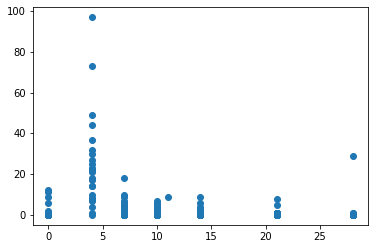

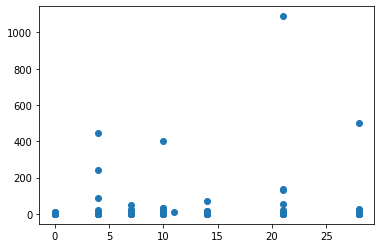

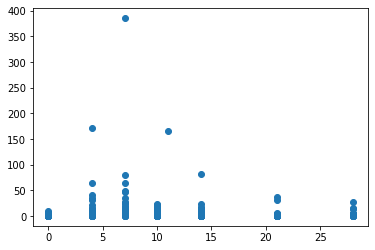

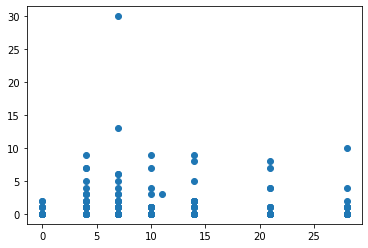

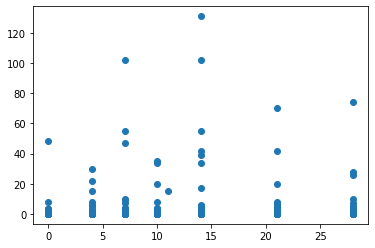

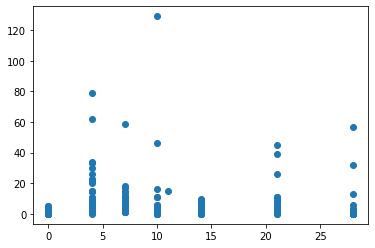

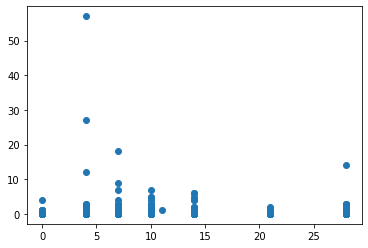

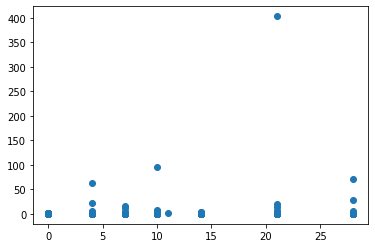

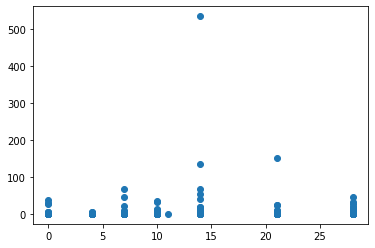

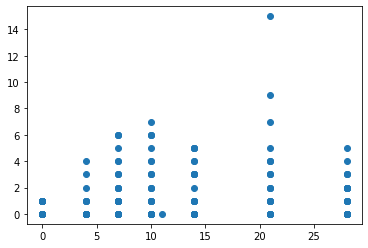

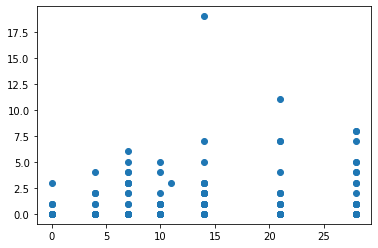

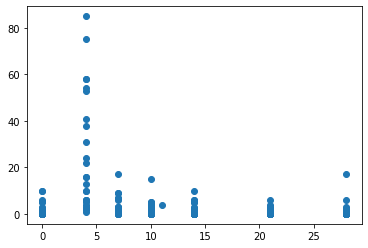

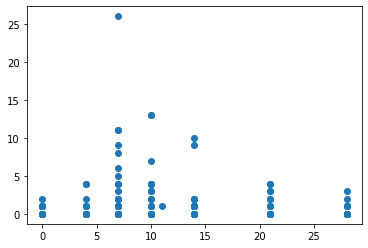

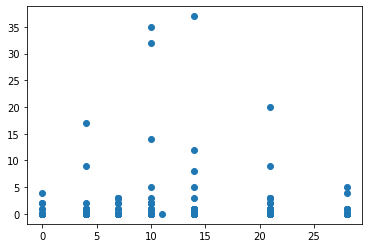

In [26]:
for (columnName, columnData) in df.iteritems():
    plt.scatter(dpi, columnData)
    plt.show()